In [1]:
# To do

#1.1. Clean Notebook - ok

#1.2. Test Simulation -ok

#1.3. Check Dimensions of Parameters - ok

#1.4. Validate Model - Check for equilibria, calculate relevant quantities from article - ok

#1.4.1 Find Error in equilibria - Might be script or formula. - Formula - Found error - ok

#1.4.2 Check formula for the vegetation - Should be periodic, it`s growing

#1.5 - visualization

#1.6 Correct article

#2 - Simulate different situations

#3 -  simulate with time between cleanings as a parameter

#4 - simulate with poisson process cleaning

#5 - simulate with human behaviour model


In [1]:
from sympy import Dummy, lambdify
from numpy import array, hstack, zeros, linspace, pi, ones
from numpy.linalg import solve
from scipy.integrate import odeint
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
#Vegetação periodica em função do tempo:
#Caso queiramos utilizar a vegetação começando não periodica, esta deve ser incluida na eq diferencial

def V_f(t):
    return 1 - (gamma_f * np.exp(-r_v* (t % tau)))/(1 - (1 - gamma_f)*np.exp(-r_v*tau))
    
    
def V_c(t):
    return 1 - (gamma_n * np.exp(-r_v* (t % tau)))/(1 - (1 - gamma_n)*np.exp(-r_v*tau))

In [5]:
#Carrying capacities em função da vegetação:

# Mudar de forma que K_i(0) \neq 0, i \in {f,c}

def K_f(v):
    #K_f is sigmoid
    #Defining Parameters 
    L = K_f_max # Maximum carrying capacity
    k = 5 #Steepness
    x_0 = 0.5 #Sigmoid midpoint
    
    return L/(1 + np.exp(-k*(v - x_0)))
    
    
def K_c(v):
    #K_c is affine
    #Defining Parameters
    L = K_c_max # maximum carrying capacity
    
    return L*v
    
    


In [7]:
# Derivadas com vegetação variando

def right_hand_side(x , t):
    """Returns the derivatives of the states.

    Parameters
    ----------
    x : ndarray, shape(6,1)
        The current state vector.
    t : float
        The current time.
    args : ndarray
        The constants.

    Returns
    -------
    dx : ndarray, shape(6,1)
        The derivative of the state.
    
    """
    S = x[0]
    I = x[1]
    M_S = x[2]
    M_I = x[3]
    L_f = x[4]
    L_c = x[5]     
    
    S_dot = - beta * S * M_I + alpha * I
    I_dot = beta * S * M_I - alpha * I
    M_I_dot = beta_hat * I * M_S - mu_M * M_I
    M_S_dot = kappa * (L_f + L_c) - beta_hat * I * M_S - mu_M * M_S
    L_f_dot = r * b * (K_f(V_f(t))/(K_f(V_f(t)) + K_c(V_c(t)))) * (M_I + M_S) * (1 - L_f/K_f(V_f(t))) - (kappa + mu_L + mu_f*(1 - V_f(t)))*L_f
    L_c_dot = r * b * (K_c(V_c(t))/(K_f(V_f(t)) + K_c(V_c(t)))) * (M_I + M_S) * (1 - L_c/K_c(V_c(t))) - (kappa + mu_L)*L_c
    
    dx = np.array([S_dot,I_dot,M_S_dot,M_I_dot,L_f_dot,L_c_dot])
    
    return dx

In [8]:
# Derivadas com Carrying capacity constante

def right_hand_side_ctt_carrying_capacity(x,t):
    """Returns the derivatives of the states.

    Parameters
    ----------
    x : ndarray, shape(6,1)
        The current state vector.
    t : float
        The current time.
    args : ndarray
        The constants.

    Returns
    -------
    dx : ndarray, shape(6,1)
        The derivative of the state.
    
    """
    S = x[0]
    I = x[1]
    M_S = x[2]
    M_I = x[3]
    L_f = x[4]
    L_c = x[5]     
    
    S_dot = - beta * S * M_I + alpha * I
    I_dot = beta * S * M_I - alpha * I
    M_I_dot = beta_hat * I * M_S - mu_M * M_I
    M_S_dot = kappa * (L_f + L_c) - beta_hat * I * M_S - mu_M * M_S
    L_f_dot = r * b * (K_f_max/(K_f_max + K_c_max)) * (M_I + M_S) * (1 - L_f/K_f_max) - (kappa + mu_L + mu_f*(1 - V_f(t)))*L_f
    L_c_dot = r * b * (K_c_max/(K_f_max + K_c_max)) * (M_I + M_S) * (1 - L_c/K_c_max) - (kappa + mu_L)*L_c
    
    dx = np.array([S_dot,I_dot,M_S_dot,M_I_dot,L_f_dot,L_c_dot])
    
    return dx

In [6]:
# Valores Relevantes
N = (r*b*kappa)/((kappa + mu_L)*mu_M)# Número de descendentes básico

R_0_max = np.sqrt((beta*beta/(alpha*mu_M))*(K_c_max + K_f_max)*(1 - 1/N))

def R_0(t): # Número de reprodução Básico em função do tempo 
    return np.sqrt((beta*beta/(alpha*mu_M))*(K_c(V_c(t)) + K_f(V_f(t)))*(1 - 1/N))

#Equilibrio E_1

E_1MI = (beta/(mu_M + beta))*(K_f_max + K_c_max)*(1 - 1/N)*(kappa/mu_M - 1/(R_0_max**2))

E_1MS = (kappa/mu_M)*(K_f_max+K_c_max)*(1 - 1/N) - E_1MI

E_1 = [(alpha/(alpha + beta*E_1MI)), (beta*E_1MI/(alpha + beta*E_1MI)), E_1MS, E_1MI, K_f_max*(1 - 1/N), K_c_max*(1-1/N)  ]

#Equilibrio E_2

E_2 = [1,0,(kappa/mu_M)*(K_f_max + K_c_max)*(1 - 1/N),0,K_f_max*(1 - 1/N),K_c_max*(1-1/N)]

In [11]:
#Valor das Constantes
beta = 0.5 # 0 - 1 per mosquito #
alpha = 1/11 # 1/11 dimensionless
beta_hat = beta # Per Mosquito
mu_M = 0.16 # 0.16 - 0.23 per day
kappa = 1/15.6 # 1/15.6 +- 2.86 per day
r = 0.5 # dimensionless
b = 83 # 83 +- 48 larvae/per female mosquito
mu_L = 0.62 #0.62 - 0.99 per day - Larvae mortality on ponds without fish
mu_f = 0

#Parametros da Vegetação

r_v = 0.5/30 # 0.5 Por Mês 
gamma_f = 0.65 # Proporção de vegetação retirada na limpeza
gamma_n = 0.5 # < 0.65  Proporção de vegetação retirada na limpeza
tau = 5 # 1 - 5 dias

#Valor das Carrying Capacities Maximas
K_f_max = 0.4
K_c_max = 4

In [14]:
x0 = np.array([0.9,0.1,0.5,0,9.588,9.588]) #Initial conditions

t = linspace(0, 300, 30000)                 # Time vector
y = odeint(right_hand_side, x0, t)         # Actual integration

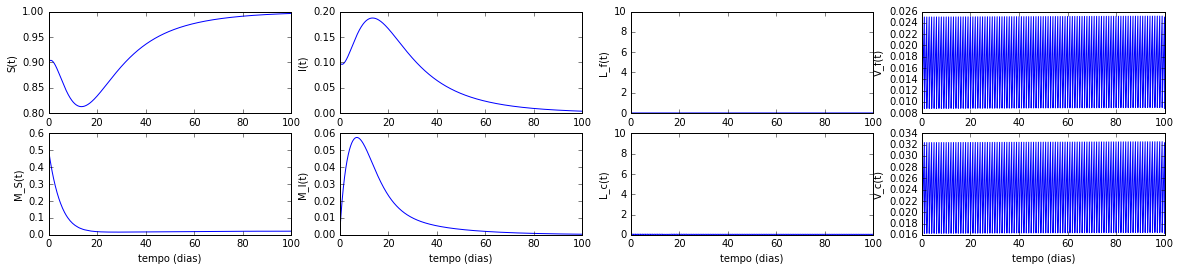

In [64]:

fig, axs = plt.subplots(2,4, figsize=(20, 4))

axs[0, 0].plot(t, y[:,0])
axs[0, 0].set_xlabel('tempo (dias)')
axs[0, 0].set_ylabel('S(t)')

axs[0, 1].plot(t, y[:,1])
axs[0, 1].set_xlabel('tempo (dias)')
axs[0, 1].set_ylabel('I(t)')



axs[1, 0].plot(t, y[:,2])
axs[1, 0].set_xlabel('tempo (dias)')
axs[1, 0].set_ylabel('M_S(t)')


axs[1, 1].plot(t, y[:,3])
axs[1, 1].set_xlabel('tempo (dias)')
axs[1, 1].set_ylabel('M_I(t)')


axs[0, 2].plot(t, y[:,4])
axs[0, 2].set_xlabel('tempo (dias)')
axs[0, 2].set_ylabel('L_f(t)')

axs[1, 2].plot(t, y[:,5])
axs[1, 2].set_xlabel('tempo (dias)')
axs[1, 2].set_ylabel('L_c(t)')

axs[0, 3].plot(t, V_f(t))
axs[0, 3].set_xlabel('tempo (dias)')
axs[0, 3].set_ylabel('V_f(t)')

axs[1,3].plot(t, V_c(t))
axs[1,3].set_xlabel('tempo (dias)')
axs[1,3].set_ylabel('V_c(t)')

plt.show()

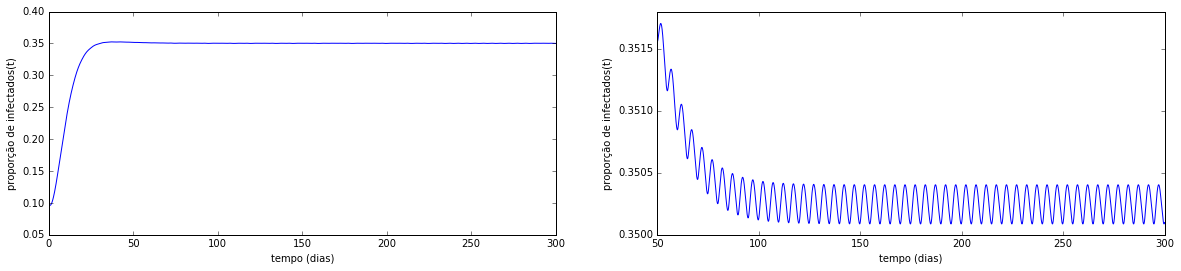

In [22]:
fig, axs = plt.subplots(1,2, figsize=(20, 4))

axs[0].plot(t, y[:,1])
axs[0].set_xlabel('tempo (dias)')
axs[0].set_ylabel('proporção de infectados(t)')

axs[1].plot( t[5000:], y[5000:,1])
axs[1].set_xlabel('tempo (dias)')
axs[1].set_ylabel('proporção de infectados(t)')

In [16]:
r_0 = R_0(t)

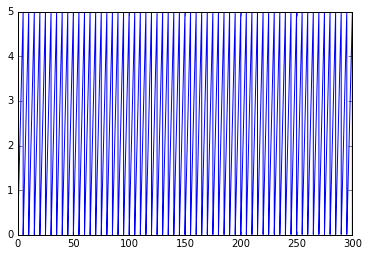

In [18]:
plt.plot( t, t % tau) # Blue line is y(t) for t in [0, 1]

#plt.xlim([0, 1])
#plt.ylim([0, 1])

In [51]:
t = linspace(0,100,10000)
t % tau

array([ 0.      ,  0.010001,  0.020002, ...,  4.979998,  4.989999,  0.      ])

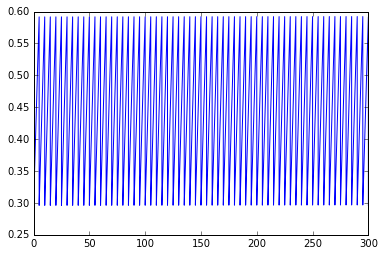

In [17]:
plt.plot(t, K_c(V_c(t)))